In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, hamming_loss, jaccard_score)
from sklearn.multioutput import MultiOutputClassifier
import joblib
import time
import os
from IPython.display import display, Markdown, HTML
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
def load_data(data_path):
    """Load and display initial dataset information"""
    print(f"1. Data Loading")
    print(f"Loading data from {data_path}")
    
    # Load the dataset
    data = pd.read_csv(data_path)
    
    print(f"Dataset loaded successfully with shape: {data.shape}")
    print("Sample data:")
    display(data.head())
    
    return data

In [3]:
def preprocess_data(data):
    """Preprocess data and perform exploratory analysis"""
    print("\n2. Data Preprocessing and Exploratory Analysis")
    
    # Separate features and target variables
    feature_cols = ['DO', 'pH', 'Alkalinity', 'Hardness', 'Nitrite', 'H2S', 'Salinity', 'Ammonia', 'Temperature']
    target_cols = ['WSS', 'AHPND', 'TSV', 'YHV']
    
    X = data[feature_cols]
    y = data[target_cols]
    
    # Display feature statistics
    print("Feature Statistics:")
    display(X.describe())
    
    # Visualize feature distributions
    print("Feature Distributions:")
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, col in enumerate(feature_cols):
        sns.histplot(X[col], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Visualize class distribution
    print("\nClass Distribution:")
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for i, col in enumerate(target_cols):
        sns.countplot(x=y[col], ax=axes[i], palette='viridis')
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
        
        # Add count labels
        for p in axes[i].patches:
            axes[i].annotate(f'{int(p.get_height())}', 
                             (p.get_x() + p.get_width() / 2., p.get_height()), 
                             ha = 'center', va = 'bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Check for missing values
    if data.isnull().sum().sum() == 0:
        print("\nNo missing values detected.")
    else:
        print("\nMissing values detected:")
        display(data.isnull().sum())
    
    # Visualize feature correlations
    print("\nFeature Correlations:")
    plt.figure(figsize=(12, 10))
    correlation = X.corr()
    mask = np.triu(correlation)
    sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Visualize disease co-occurrence
    print("\nDisease Co-occurrence:")
    plt.figure(figsize=(10, 8))
    disease_corr = y.corr()
    sns.heatmap(disease_corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Disease Co-occurrence Matrix')
    plt.tight_layout()
    plt.show()
    
    # Visualize feature scaling effect
    print("\nFeature Scaling Effect:")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Before scaling
    sns.boxplot(data=X, ax=axes[0])
    axes[0].set_title('Feature Distribution Before Scaling')
    axes[0].set_xlabel('Features')
    axes[0].set_ylabel('Value')
    axes[0].tick_params(axis='x', rotation=90)
    
    # After scaling
    sns.boxplot(data=X_scaled_df, ax=axes[1])
    axes[1].set_title('Feature Distribution After Scaling')
    axes[1].set_xlabel('Features')
    axes[1].set_ylabel('Standardized Value')
    axes[1].tick_params(axis='x', rotation=90)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nFeatures shape after preprocessing: {X.shape}")
    print(f"Labels shape after preprocessing: {y.shape}")
    
    return X, y, feature_cols, target_cols, scaler

In [4]:
def split_data(X, y, test_size=0.2, random_state=42):
    """Split data into train and test sets"""
    print("\n3. Train-Test Split")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Testing set size: {X_test.shape[0]} samples")
    
    return X_train, X_test, y_train, y_test

In [19]:
def tune_hyperparameters(X_train, y_train, random_state=42):
    """Tune SVM hyperparameters using Grid Search for all disease targets"""
    print(f"\n4. Hyperparameter Tuning for SVM")
    print(f"Tuning hyperparameters using all disease targets simultaneously...")
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Define parameter grid
    param_grid = {
        'estimator__C': [0.1, 1, 10, 100],
        'estimator__gamma': ['scale', 'auto', 0.1, 0.01],
        'estimator__kernel': ['rbf', 'linear', 'poly', 'sigmoid']
    }
    
    # Initialize base SVM model
    base_model = SVC(probability=True, random_state=random_state)
    
    # Create MultiOutputClassifier with SVM
    svm_model = MultiOutputClassifier(base_model)
    
    print("Starting hyperparameter search for SVM (this may take a while)...")
    start_time = time.time()
    
    # Perform Grid Search
    grid_search = GridSearchCV(
        svm_model, 
        param_grid, 
        scoring='accuracy', 
        cv=3, 
        n_jobs=-1, 
        verbose=1
    )
    
    # Use all disease targets
    grid_search.fit(X_train_scaled, y_train)
    
    end_time = time.time()
    
    print(f"Hyperparameter tuning completed in {end_time - start_time:.2f} seconds.")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Display results
    print("Hyperparameter Search Results:")
    results_df = pd.DataFrame(grid_search.best_params_.items(), columns=['Parameter', 'Value'])
    display(HTML("<b>Best SVM Hyperparameters:</b>"))
    display(results_df)
    
    # Visualize hyperparameter search results
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Plot performance for different kernels
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='param_estimator__kernel', y='mean_test_score', data=results)
    plt.title('Performance by Kernel Type')
    plt.xlabel('Kernel')
    plt.ylabel('Cross-Validation Accuracy')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot performance by C and gamma for the best kernel
    best_kernel = grid_search.best_params_['estimator__kernel']
    kernel_results = results[results['param_estimator__kernel'] == best_kernel]
    
    plt.figure(figsize=(12, 8))
    pivot = kernel_results.pivot_table(
        values='mean_test_score', 
        index='param_estimator__C', 
        columns='param_estimator__gamma'
    )
    sns.heatmap(pivot, annot=True, fmt='.4f', cmap='viridis')
    plt.title(f'Performance by C and Gamma (Kernel: {best_kernel})')
    plt.tight_layout()
    plt.show()
    
    return grid_search.best_params_

In [8]:
def train_svm_models(X_train, X_test, y_train, y_test, best_params, target_cols, random_state=42):
    """Train SVM models with tuned hyperparameters"""
    print("\n5. Training SVM Models")
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    models = {}
    results = {}
    confusion_matrices = {}
    
    for target in target_cols:
        print(f"\nTraining SVM for {target}...")
        start_time = time.time()
        
        # Create SVM model with best parameters
        svm = SVC(
            C=best_params['estimator__C'],
            gamma=best_params['estimator__gamma'],
            kernel=best_params['estimator__kernel'],
            probability=True,
            random_state=random_state
        )
        
        # Train model
        svm.fit(X_train_scaled, y_train[target])
        
        # Make predictions
        y_pred = svm.predict(X_test_scaled)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test[target], y_pred)
        precision = precision_score(y_test[target], y_pred)
        recall = recall_score(y_test[target], y_pred)
        f1 = f1_score(y_test[target], y_pred)
        
        end_time = time.time()
        training_time = end_time - start_time
        
        # Store results
        results[target] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'training_time': training_time
        }
        
        # Store confusion matrix
        cm = confusion_matrix(y_test[target], y_pred)
        confusion_matrices[target] = cm
        
        # Store model
        models[target] = svm
        
        # Print results
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        print(f"  Training time: {training_time:.2f} seconds")
    
    # Visualize confusion matrices
    print("\nConfusion Matrices:")
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    for i, target in enumerate(target_cols):
        cm = confusion_matrices[target]
        sns.heatmap(
            cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            ax=axes[i],
            cbar=False
        )
        axes[i].set_title(f'Confusion Matrix for {target}')
        axes[i].set_xlabel('Predicted Labels')
        axes[i].set_ylabel('True Labels')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate overall performance metrics
    all_y_true = np.hstack([y_test[col].values.reshape(-1, 1) for col in target_cols])
    all_y_pred = np.hstack([models[col].predict(X_test_scaled).reshape(-1, 1) for col in target_cols])
    
    overall_accuracy = accuracy_score(all_y_true.flatten(), all_y_pred.flatten())
    overall_hamming_loss = hamming_loss(all_y_true, all_y_pred)
    overall_jaccard = jaccard_score(all_y_true, all_y_pred, average='samples')
    
    print("\nOverall Model Performance:")
    print(f"Accuracy: {overall_accuracy:.4f}")
    print(f"Hamming Loss: {overall_hamming_loss:.4f}")
    print(f"Jaccard Score: {overall_jaccard:.4f}")
    
    # Feature importance analysis (for linear kernel only)
    if best_params['estimator__kernel'] == 'linear':
        print("\nFeature Importance Analysis:")
        
        feature_cols = X_train.columns
        importance_data = []
        
        for target in target_cols:
            if hasattr(models[target], 'coef_'):
                importance = np.abs(models[target].coef_[0])
                importance_data.append(pd.Series(importance, index=feature_cols, name=target))
        
        if importance_data:
            importance_df = pd.concat(importance_data, axis=1)
            
            plt.figure(figsize=(12, 8))
            sns.heatmap(importance_df, annot=True, fmt='.3f', cmap='YlGnBu')
            plt.title('Feature Importance (Coefficient Magnitude)')
            plt.tight_layout()
            plt.show()
            
            # Plot top features for each disease
            plt.figure(figsize=(14, 10))
            
            for i, target in enumerate(target_cols):
                if target in importance_df.columns:
                    plt.subplot(2, 2, i+1)
                    importance_df[target].sort_values().plot(kind='barh')
                    plt.title(f'Feature Importance for {target}')
                    plt.tight_layout()
            
            plt.tight_layout()
            plt.show()
    else:
        print("\nFeature importance analysis not available for non-linear kernels.")
    return models, results, confusion_matrices, scaler

In [9]:
def save_models(models, scaler, feature_cols, target_cols, output_dir='model'):
    """Save models and artifacts to disk"""
    print("\n6. Saving Models and Artifacts")
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save models
    for target, model in models.items():
        model_path = os.path.join(output_dir, f'svm_model_{target}.pkl')
        joblib.dump(model, model_path)
        print(f"Saved model for {target} to {model_path}")
    
    # Save scaler
    scaler_path = os.path.join(output_dir, 'scaler.pkl')
    joblib.dump(scaler, scaler_path)
    print(f"Saved scaler to {scaler_path}")
    
    # Save metadata
    metadata = {
        'feature_columns': feature_cols,
        'target_columns': target_cols,
        'date_created': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    metadata_path = os.path.join(output_dir, 'metadata.pkl')
    joblib.dump(metadata, metadata_path)
    print(f"Saved metadata to {metadata_path}")
    
    # Create and save model summary
    summary = [
        "# SVM Model Summary",
        f"Date created: {metadata['date_created']}",
        f"Features: {', '.join(feature_cols)}",
        f"Targets: {', '.join(target_cols)}",
        f"Models: {', '.join([f'svm_model_{target}.pkl' for target in target_cols])}",
    ]
    
    summary_path = os.path.join(output_dir, 'model_summary.txt')
    with open(summary_path, 'w') as f:
        f.write('\n'.join(summary))
    
    print(f"Saved model summary to {summary_path}")

In [10]:
def cross_validate_models(X, y, best_params, target_cols, n_folds=5, random_state=42):
    """Perform cross-validation on SVM models"""
    print("\n7. Cross-Validation Evaluation")
    print(f"Performing {n_folds}-fold cross-validation...")
    
    # Define folds
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    # Initialize results storage
    cv_results = {target: {'accuracy': [], 'precision': [], 'recall': [], 'f1': []} for target in target_cols}
    overall_results = {'accuracy': [], 'hamming_loss': []}
    
    # Perform cross-validation
    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        print(f"\nFold {fold}/{n_folds}")
        
        # Split data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        all_y_true = []
        all_y_pred = []
        
        # Train and evaluate models for each target
        for target in target_cols:
            print(f"  Training for {target}...")
            
            # Create SVM model with best parameters
            svm = SVC(
                C=best_params['estimator__C'],
                gamma=best_params['estimator__gamma'],
                kernel=best_params['estimator__kernel'],
                probability=True,
                random_state=random_state
            )
            
            # Train model
            svm.fit(X_train_scaled, y_train[target])
            
            # Make predictions
            y_pred = svm.predict(X_test_scaled)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test[target], y_pred)
            precision = precision_score(y_test[target], y_pred)
            recall = recall_score(y_test[target], y_pred)
            f1 = f1_score(y_test[target], y_pred)
            
            # Store results
            cv_results[target]['accuracy'].append(accuracy)
            cv_results[target]['precision'].append(precision)
            cv_results[target]['recall'].append(recall)
            cv_results[target]['f1'].append(f1)
            
            print(f"    Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
            
            # Store for overall metrics
            all_y_true.append(y_test[target].values.reshape(-1, 1))
            all_y_pred.append(y_pred.reshape(-1, 1))
        
        # Calculate overall metrics
        all_y_true_np = np.hstack(all_y_true)
        all_y_pred_np = np.hstack(all_y_pred)
        
        overall_accuracy = accuracy_score(all_y_true_np.flatten(), all_y_pred_np.flatten())
        overall_hamming_loss = hamming_loss(all_y_true_np, all_y_pred_np)
        
        overall_results['accuracy'].append(overall_accuracy)
        overall_results['hamming_loss'].append(overall_hamming_loss)
        
        print(f"  Overall Accuracy: {overall_accuracy:.4f}, Hamming Loss: {overall_hamming_loss:.4f}")
    
    # Summarize cross-validation results
    print("\nCross-Validation Summary:")
    cv_summary = []
    
    for target in target_cols:
        target_results = {
            'Disease': target,
            'Accuracy': f"{np.mean(cv_results[target]['accuracy']):.4f} ± {np.std(cv_results[target]['accuracy']):.4f}",
            'Precision': f"{np.mean(cv_results[target]['precision']):.4f} ± {np.std(cv_results[target]['precision']):.4f}",
            'Recall': f"{np.mean(cv_results[target]['recall']):.4f} ± {np.std(cv_results[target]['recall']):.4f}",
            'F1 Score': f"{np.mean(cv_results[target]['f1']):.4f} ± {np.std(cv_results[target]['f1']):.4f}"
        }
        cv_summary.append(target_results)
    
    # Add overall results
    overall_result = {
        'Disease': 'Overall',
        'Accuracy': f"{np.mean(overall_results['accuracy']):.4f} ± {np.std(overall_results['accuracy']):.4f}",
        'Precision': 'N/A',
        'Recall': 'N/A',
        'F1 Score': f"{(np.mean(overall_results['accuracy']) - np.mean(overall_results['hamming_loss'])):.4f} ± {np.std(overall_results['accuracy']):.4f}"
    }
    cv_summary.append(overall_result)
    
    # Display results
    cv_summary_df = pd.DataFrame(cv_summary)
    display(cv_summary_df)
    
    # Visualize cross-validation performance
    print("Cross-Validation Performance Visualization:")
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    disease_means = {}
    disease_std = {}
    
    for target in target_cols:
        disease_means[target] = [
            np.mean(cv_results[target]['accuracy']),
            np.mean(cv_results[target]['precision']),
            np.mean(cv_results[target]['recall']),
            np.mean(cv_results[target]['f1'])
        ]
        
        disease_std[target] = [
            np.std(cv_results[target]['accuracy']),
            np.std(cv_results[target]['precision']),
            np.std(cv_results[target]['recall']),
            np.std(cv_results[target]['f1'])
        ]
    
    # Create performance plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.2
    index = np.arange(len(metrics))
    
    for i, target in enumerate(target_cols):
        position = index + i * bar_width
        bars = ax.bar(position, disease_means[target], bar_width, 
                      label=target, alpha=0.8, capsize=5)
        
        # Add error bars
        ax.errorbar(position, disease_means[target], yerr=disease_std[target], 
                    fmt='none', ecolor='black', capsize=5)
    
    ax.set_xlabel('Metric')
    ax.set_ylabel('Score')
    ax.set_title('Cross-Validation Performance by Disease')
    ax.set_xticks(index + bar_width * (len(target_cols) - 1) / 2)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Set y-axis to start at 0.8 for better visualization of differences
    ax.set_ylim(0.8, 1.02)
    
    plt.tight_layout()
    plt.show()
    
    return cv_summary_df

In [24]:
def predict_new_cases(models, scaler, feature_cols, target_cols, new_data,best_params, visualize=True):
    """Make predictions on new data"""
    print("\n8. Prediction on New Data")
    
    # Ensure columns match
    new_data = new_data[feature_cols].copy()
    
    # Display input data
    print("Input Data:")
    display(new_data)
    
    # Scale features
    X_new = scaler.transform(new_data)
    
    # Make predictions for each model
    predictions = []
    probabilities = {}
    
    for target in target_cols:
        # Predict class
        pred = models[target].predict(X_new)
        predictions.append(pred)
        
        # Predict probabilities
        proba = models[target].predict_proba(X_new)
        probabilities[target] = proba[:, 1]  # Probability of positive class
    
    # Convert predictions to array and then DataFrame
    predictions = np.array(predictions).T
    
    # Create probability DataFrame
    proba_data = pd.DataFrame(
        {target: probabilities[target] for target in target_cols},
        index=[f"Sample {i+1}" for i in range(X_new.shape[0])]
    )
    
    # Display probability predictions
    print("\nPrediction Probabilities:")
    plt.figure(figsize=(12, max(4, len(new_data) * 0.5)))
    
    # Use a custom heatmap for probabilities
    sns.heatmap(proba_data, cmap='YlOrRd', annot=True, fmt='.3f', cbar=True)
    plt.title('Disease Prediction Probabilities')
    plt.tight_layout()
    plt.show()
    
    # Display binary predictions
    print("\nBinary Predictions:")
    binary_data = pd.DataFrame(
        predictions, 
        columns=target_cols, 
        index=[f"Sample {i+1}" for i in range(X_new.shape[0])]
    )
    
    plt.figure(figsize=(12, max(4, len(new_data) * 0.5)))
    
    # Use a custom heatmap for binary predictions
    # Important: Use the right format specifier based on data type
    fmt = 'd' if np.issubdtype(binary_data.dtypes[0], np.integer) else '.2f'
    
    sns.heatmap(binary_data, 
                cmap=LinearSegmentedColormap.from_list("custom", ["#f7fbff", "#e74c3c"]), 
                annot=True, 
                fmt=fmt, 
                cbar=False)
    plt.title('Disease Binary Predictions (0: Negative, 1: Positive)')
    plt.tight_layout()
    plt.show()
    
    # Summarize potential risk factors based on predictions
    print("\nRisk Analysis:")
    
    for i in range(len(new_data)):
        sample_name = f"Sample {i+1}"
        predicted_diseases = [target for j, target in enumerate(target_cols) if predictions[i, j] == 1]
        
        if predicted_diseases:
            print(f"\n{sample_name} is predicted to have: {', '.join(predicted_diseases)}")
            
            # Find top contributing features for each predicted disease
            if best_params['estimator__kernel'] == 'linear':
                for disease in predicted_diseases:
                    coeffs = np.abs(models[disease].coef_[0])
                    feature_importance = pd.Series(coeffs, index=feature_cols)
                    top_features = feature_importance.nlargest(3)
                    
                    print(f"  Top risk factors for {disease}:")
                    for feature, importance in top_features.items():
                        value = new_data.iloc[i][feature]
                        print(f"    - {feature}: {value:.2f} (importance: {importance:.3f})")
            else:
                print("  (Detailed risk factor analysis not available for non-linear kernels)")
        else:
            print(f"\n{sample_name} is predicted to be healthy.")
    
    return {"probabilities": proba_data, "predictions": binary_data}

In [25]:
def run_pipeline(data_path, test_size=0.2, random_state=42):
    """Run the complete SVM pipeline"""
    print("Complete SVM Pipeline Execution")
    
    # Load data
    data = load_data(data_path)
    
    # Preprocess data
    X, y, feature_cols, target_cols, _ = preprocess_data(data)
    
    # Split data
    X_train, X_test, y_train, y_test = split_data(X, y, test_size, random_state)
    
    # Tune hyperparameters using all target diseases
    best_params = tune_hyperparameters(X_train, y_train, random_state)
    
    # Train models
    models, results, confusion_matrices, scaler = train_svm_models(
        X_train, X_test, y_train, y_test, best_params, target_cols, random_state
    )
    
    # Save models
    save_models(models, scaler, feature_cols, target_cols)
    
    # Cross-validate models
    cv_summary = cross_validate_models(X, y, best_params, target_cols)
    
    # Make predictions on new data (using first few test samples as an example)
    sample_data = pd.DataFrame(X_test[:3].values, columns=feature_cols)
    
    # Make predictions
    predictions = predict_new_cases(models, scaler, feature_cols, target_cols, sample_data,best_params)
    
    # Create final summary
    display(Markdown("## Final Pipeline Summary"))
    print("SVM pipeline completed successfully!")
    print(f"Models trained for diseases: {', '.join(target_cols)}")
    print(f"Overall accuracy: {results['WSS']['accuracy']:.4f}")
    print("Models and artifacts saved to the 'model' directory")
    
    return {
        "models": models,
        "results": results,
        "scaler": scaler,
        "feature_cols": feature_cols,
        "target_cols": target_cols,
        "best_params": best_params
    }

Complete SVM Pipeline Execution
1. Data Loading
Loading data from C:\Users\naren\Desktop\4thyear models\Untitled Folder\dataset.csv
Dataset loaded successfully with shape: (6517, 13)
Sample data:


,DO,pH,Alkalinity,Hardness,Nitrite,H2S,Salinity,Ammonia,Temperature,WSS,AHPND,TSV,YHV
0,0.21,4.75,218.36,300.13,4.36,0.07,24.44,5.90,35.18,1,1,1,1
1,11.43,3.09,273.94,8.43,2.18,0.02,10.08,0.73,36.45,0,0,0,1
2,12.43,9.65,220.81,11.73,4.90,0.07,11.29,4.88,33.51,0,1,0,1
3,10.96,4.82,266.57,6.63,3.57,0.03,23.82,0.99,30.07,0,0,0,0
4,1.36,10.24,252.11,339.89,4.66,0.06,13.43,3.81,30.72,1,1,1,1



2. Data Preprocessing and Exploratory Analysis
Feature Statistics:


,DO,pH,Alkalinity,Hardness,Nitrite,H2S,Salinity,Ammonia,Temperature
count,6517.000000,6517.000000,6517.000000,6517.000000,6517.000000,6517.000000,6517.000000,6517.000000,6517.000000
mean,5.525372,7.883738,99.744519,155.277540,0.556581,0.079333,18.794860,2.036512,32.291070
std,1.697620,1.414228,60.003889,89.406059,0.748328,0.112525,4.440123,1.837780,2.629629
min,0.030000,0.000000,20.000000,0.000000,0.000000,0.000000,10.010000,0.000000,28.000000
25%,4.310000,6.870000,48.240000,90.010000,0.020000,0.010000,14.980000,0.520000,30.010000
50%,5.430000,8.000000,94.880000,142.400000,0.350000,0.020000,20.130000,1.130000,32.210000
75%,6.660000,9.000000,121.000000,212.370000,0.650000,0.100000,22.650000,3.570000,34.560000
max,14.970000,14.850000,480.000000,816.000000,4.990000,0.490000,25.000000,6.000000,37.000000


Feature Distributions:


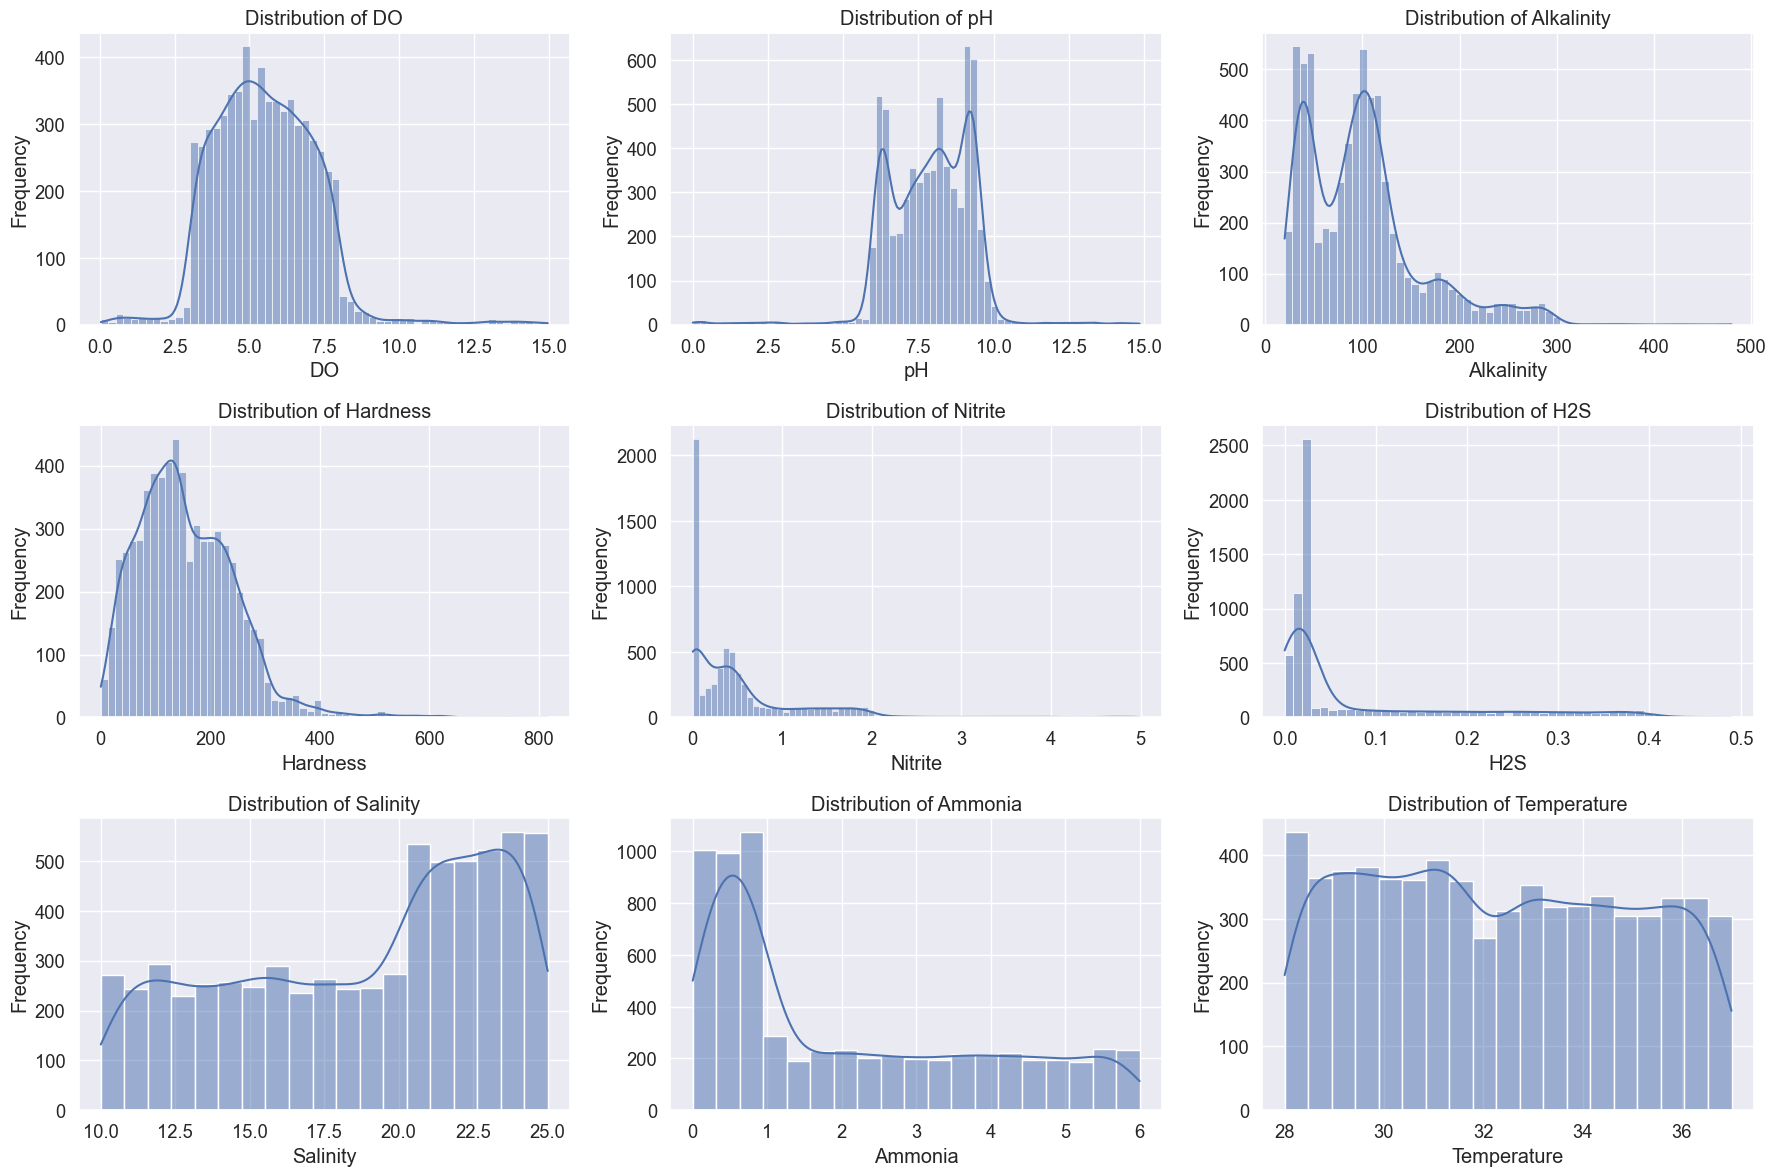


Class Distribution:


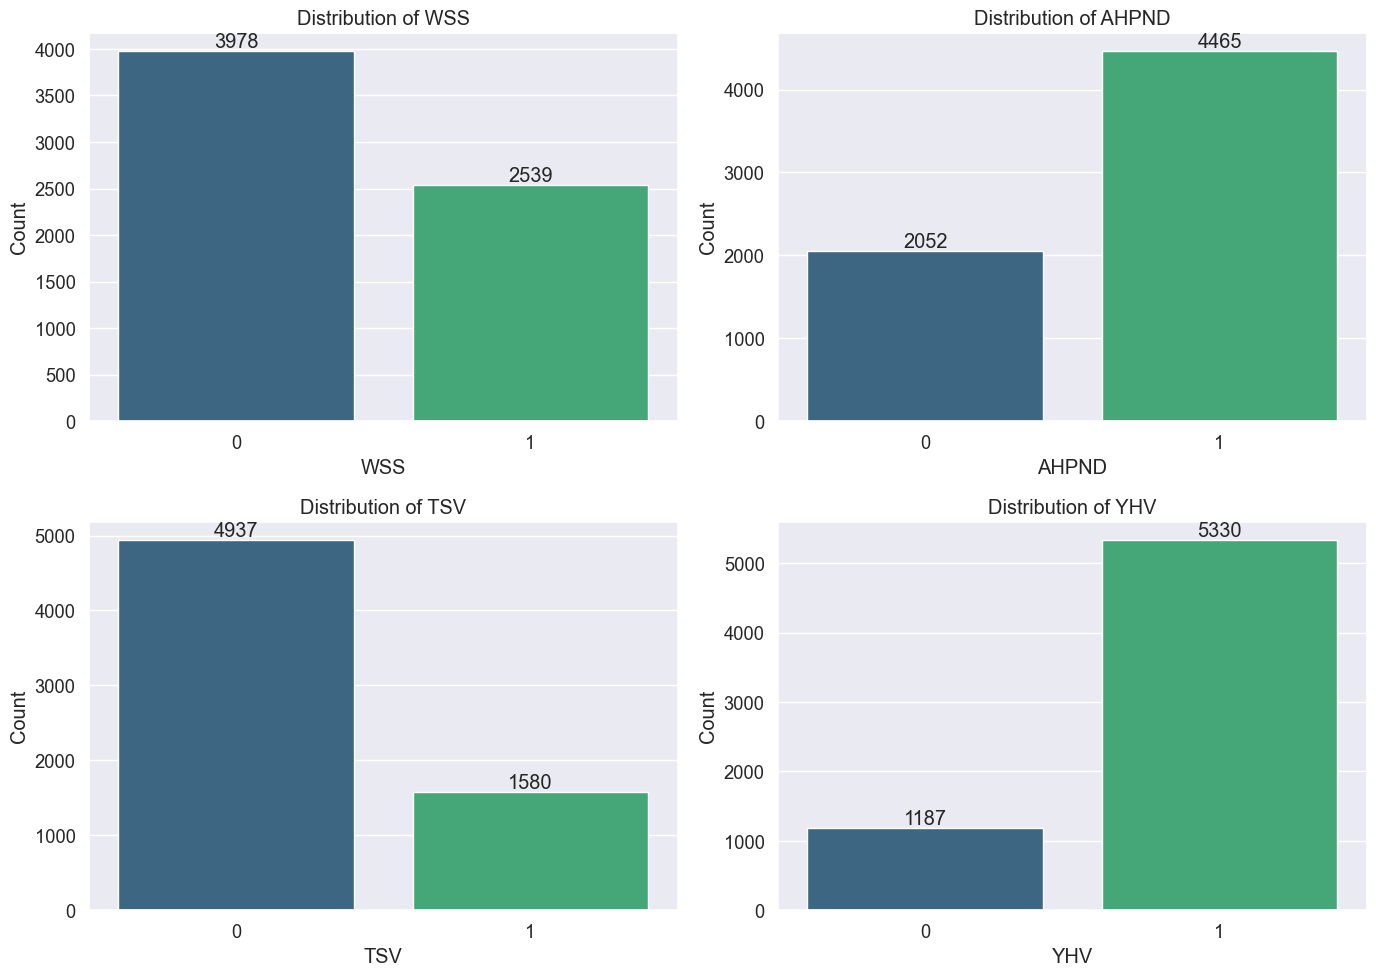


No missing values detected.

Feature Correlations:


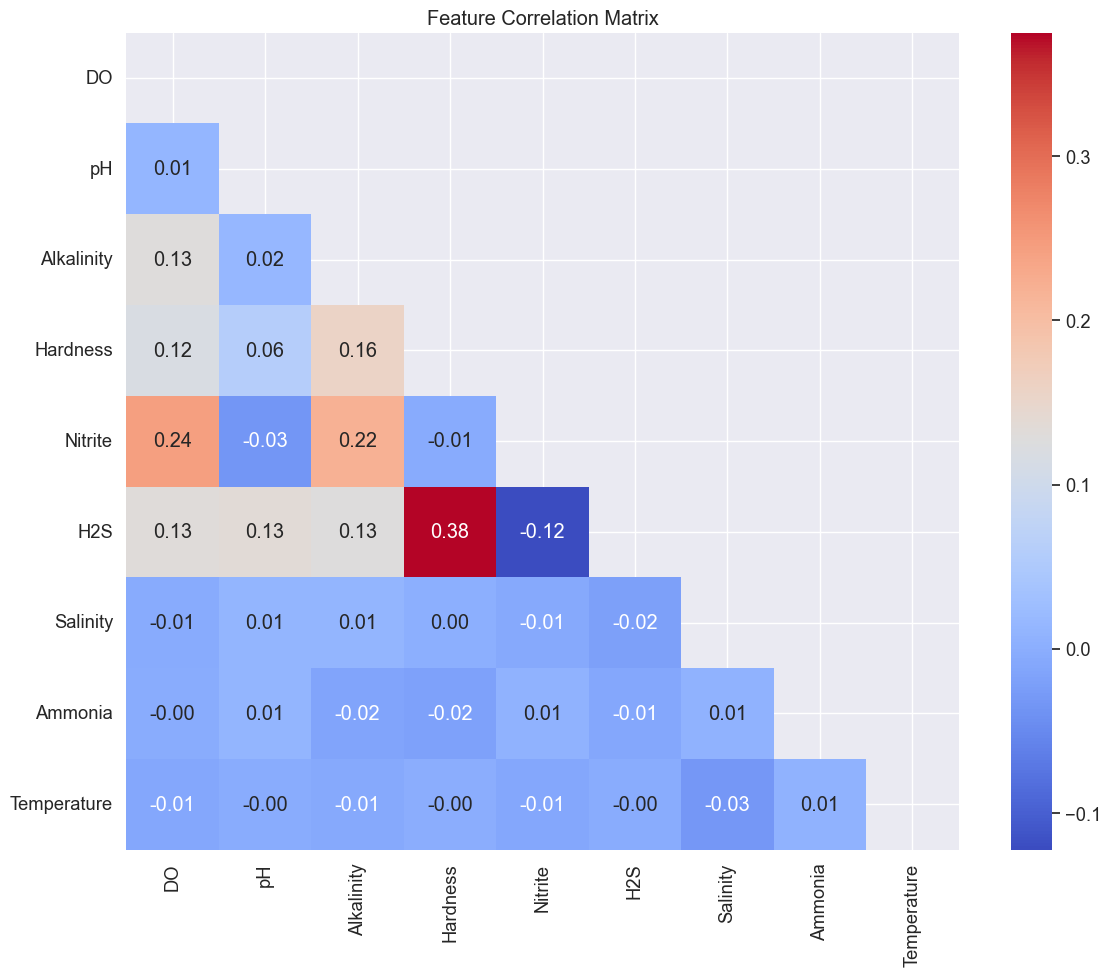


Disease Co-occurrence:


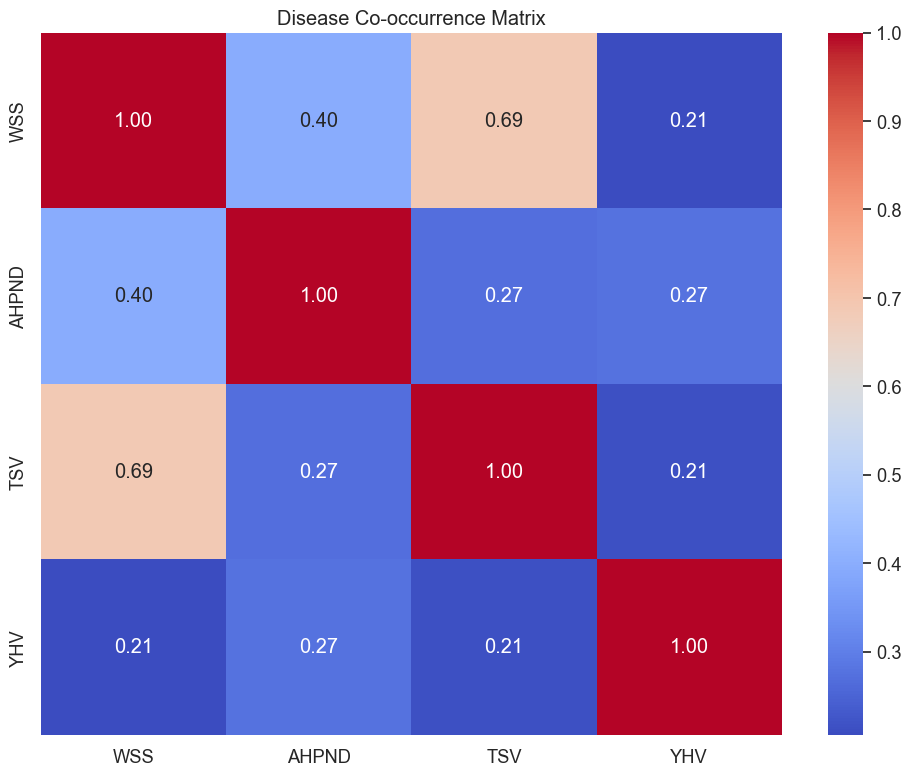


Feature Scaling Effect:


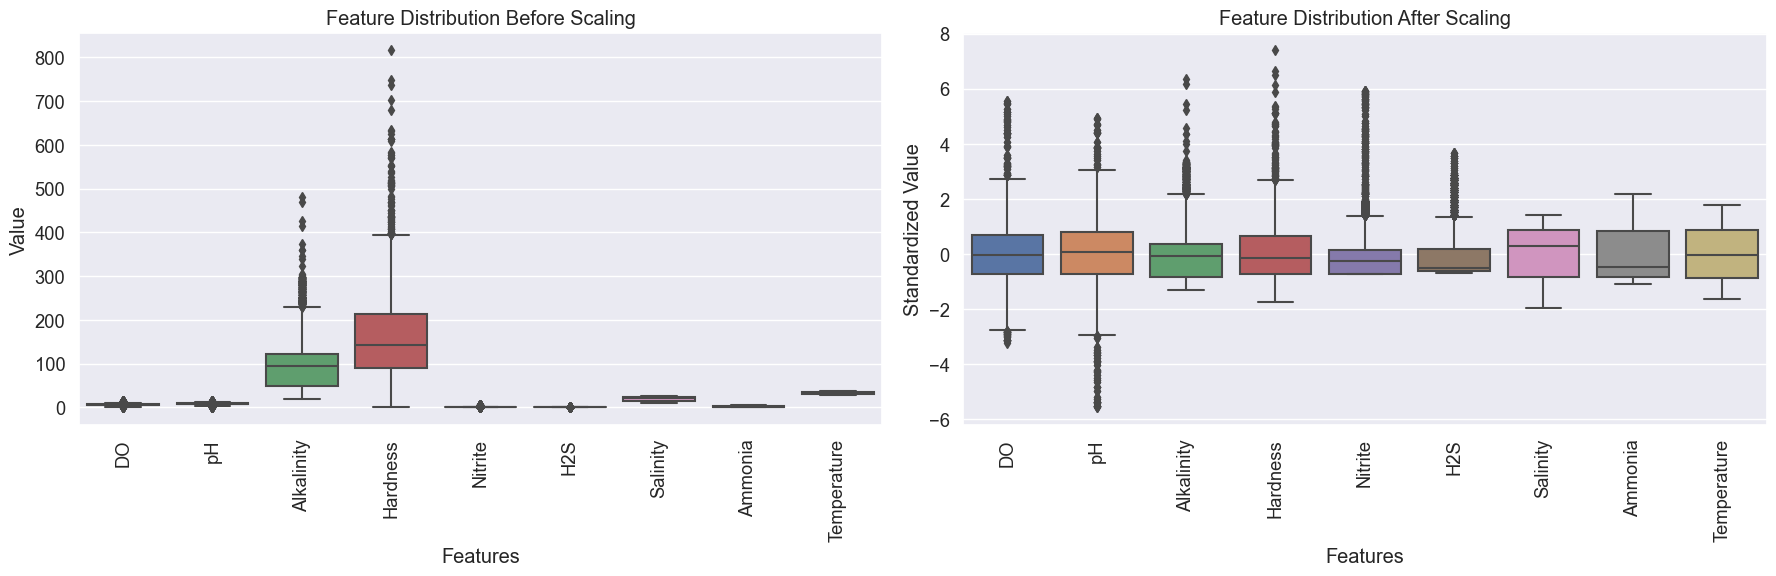


Features shape after preprocessing: (6517, 9)
Labels shape after preprocessing: (6517, 4)

3. Train-Test Split
Training set size: 5213 samples
Testing set size: 1304 samples

4. Hyperparameter Tuning for SVM
Tuning hyperparameters using all disease targets simultaneously...
Starting hyperparameter search for SVM (this may take a while)...
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Hyperparameter tuning completed in 507.43 seconds.
Best parameters: {'estimator__C': 100, 'estimator__gamma': 0.1, 'estimator__kernel': 'rbf'}
Best cross-validation score: 0.7548
Hyperparameter Search Results:


,Parameter,Value
0,estimator__C,100
1,estimator__gamma,0.1
2,estimator__kernel,rbf


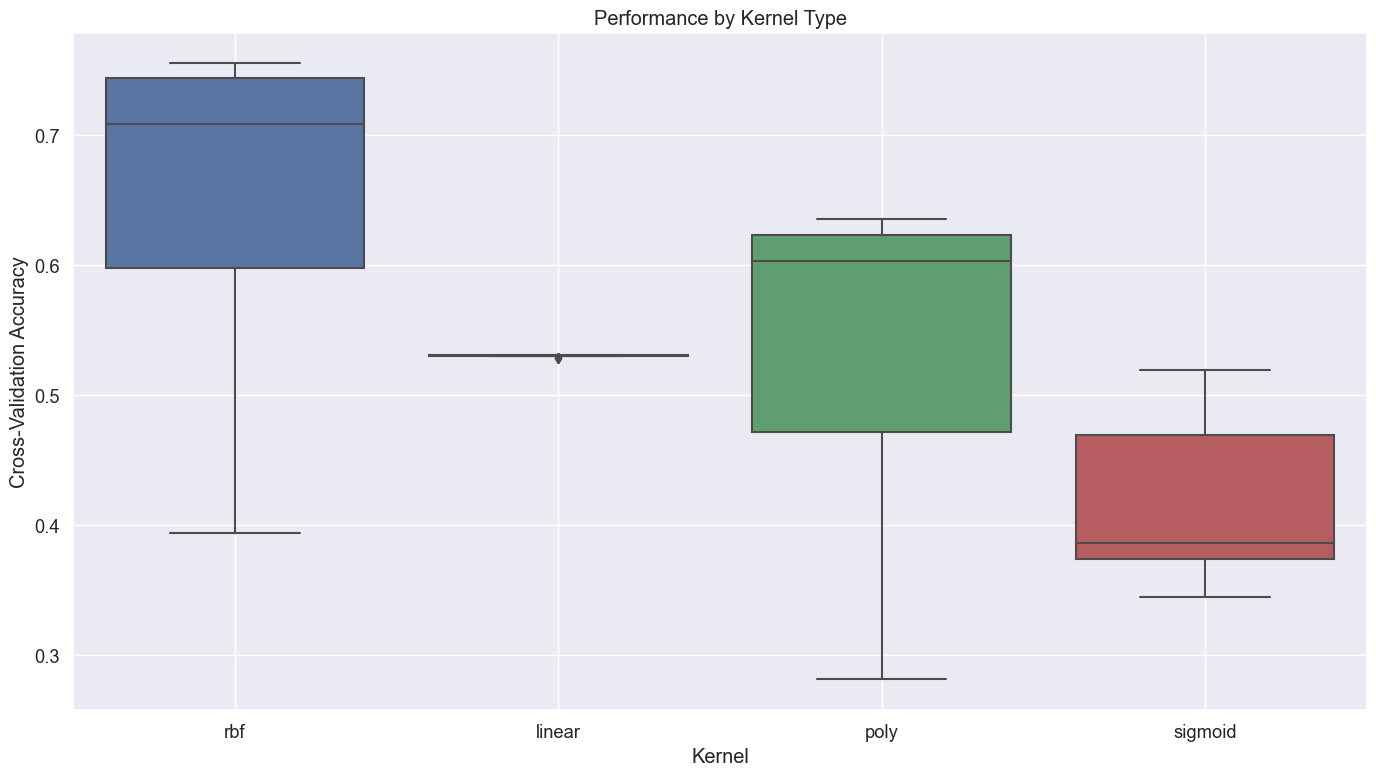

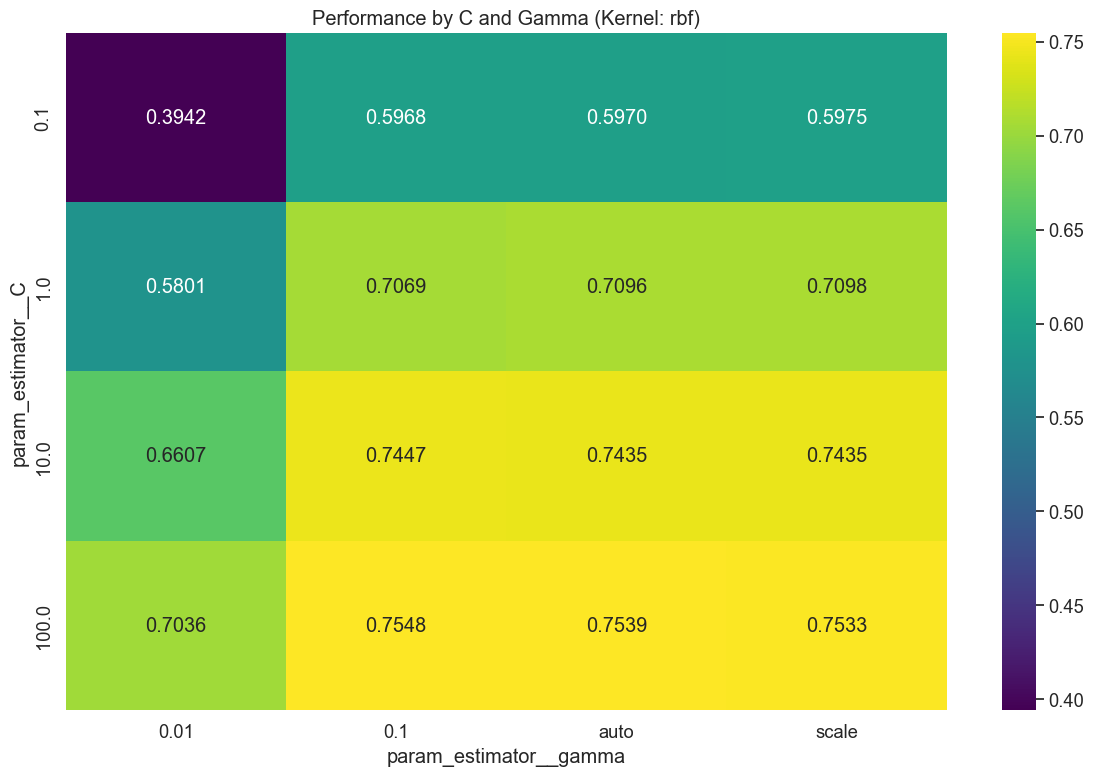


5. Training SVM Models

Training SVM for WSS...
  Accuracy: 0.9410
  Precision: 0.9180
  Recall: 0.9307
  F1 Score: 0.9243
  Training time: 2.30 seconds

Training SVM for AHPND...
  Accuracy: 0.8842
  Precision: 0.9128
  Recall: 0.9179
  F1 Score: 0.9153
  Training time: 4.59 seconds

Training SVM for TSV...
  Accuracy: 0.9640
  Precision: 0.9414
  Recall: 0.9088
  F1 Score: 0.9248
  Training time: 1.19 seconds

Training SVM for YHV...
  Accuracy: 0.9525
  Precision: 0.9661
  Recall: 0.9769
  F1 Score: 0.9715
  Training time: 1.51 seconds

Confusion Matrices:


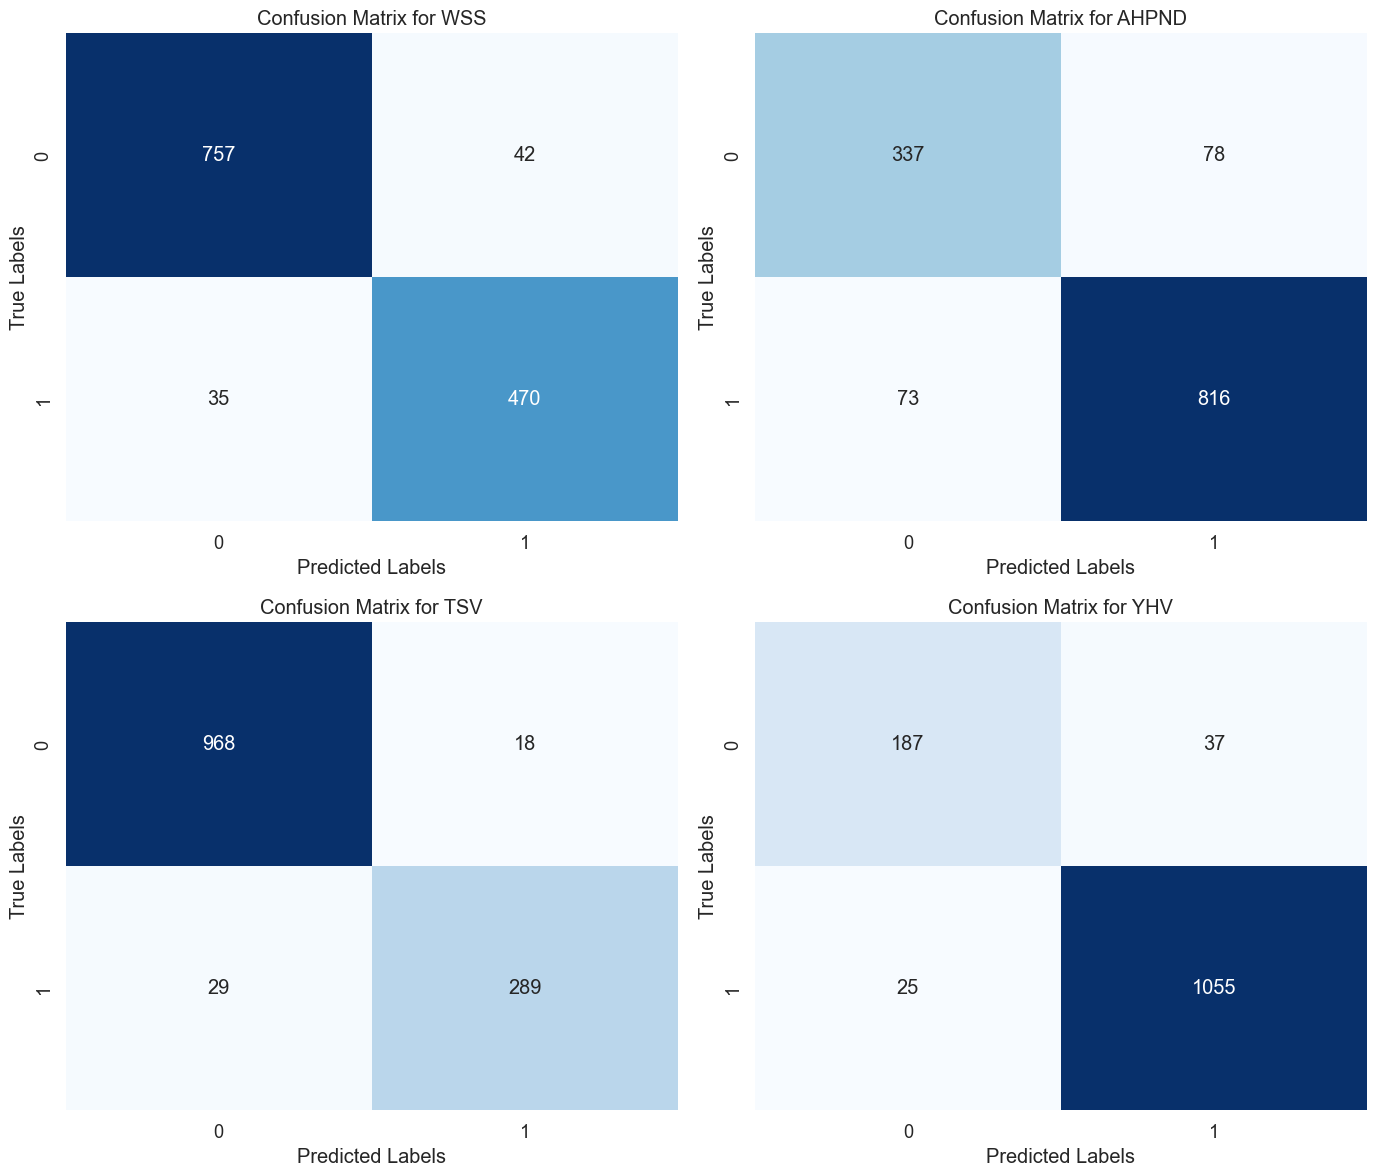


Overall Model Performance:
Accuracy: 0.9354
Hamming Loss: 0.0646
Jaccard Score: 0.8052

Feature importance analysis not available for non-linear kernels.

6. Saving Models and Artifacts
Saved model for WSS to model\svm_model_WSS.pkl
Saved model for AHPND to model\svm_model_AHPND.pkl
Saved model for TSV to model\svm_model_TSV.pkl
Saved model for YHV to model\svm_model_YHV.pkl
Saved scaler to model\scaler.pkl
Saved metadata to model\metadata.pkl
Saved model summary to model\model_summary.txt

7. Cross-Validation Evaluation
Performing 5-fold cross-validation...

Fold 1/5
  Training for WSS...
    Accuracy: 0.9410, F1: 0.9243
  Training for AHPND...
    Accuracy: 0.8842, F1: 0.9153
  Training for TSV...
    Accuracy: 0.9640, F1: 0.9248
  Training for YHV...
    Accuracy: 0.9525, F1: 0.9715
  Overall Accuracy: 0.9354, Hamming Loss: 0.0646

Fold 2/5
  Training for WSS...
    Accuracy: 0.9356, F1: 0.9148
  Training for AHPND...
    Accuracy: 0.8535, F1: 0.8897
  Training for TSV...
    Accur

,Disease,Accuracy,Precision,Recall,F1 Score
0,WSS,0.9408 ± 0.0094,0.9223 ± 0.0097,0.9263 ± 0.0133,0.9243 ± 0.0103
1,AHPND,0.8812 ± 0.0157,0.9105 ± 0.0142,0.9163 ± 0.0132,0.9134 ± 0.0132
2,TSV,0.9619 ± 0.0048,0.9170 ± 0.0215,0.9269 ± 0.0129,0.9217 ± 0.0103
3,YHV,0.9432 ± 0.0050,0.9625 ± 0.0033,0.9683 ± 0.0067,0.9654 ± 0.0033
4,Overall,0.9318 ± 0.0055,N/A,N/A,0.8636 ± 0.0055


Cross-Validation Performance Visualization:


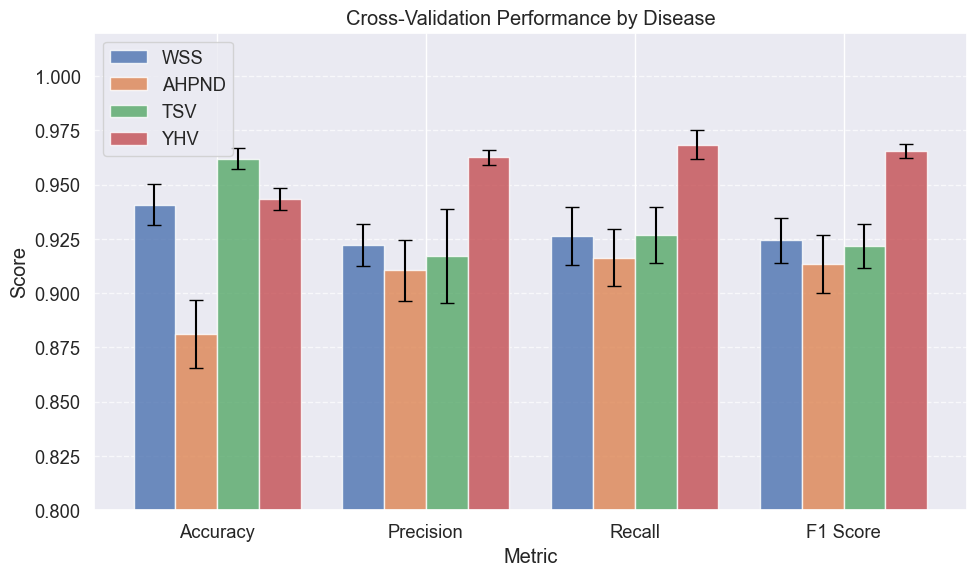


8. Prediction on New Data
Input Data:


,DO,pH,Alkalinity,Hardness,Nitrite,H2S,Salinity,Ammonia,Temperature
0,5.39,8.20,98.00,201.00,0.18,0.11,11.92,5.87,33.36
1,8.18,8.00,107.00,154.00,0.43,0.31,15.30,5.42,33.71
2,3.62,6.86,48.93,64.27,0.01,0.02,18.42,0.06,30.43



Prediction Probabilities:


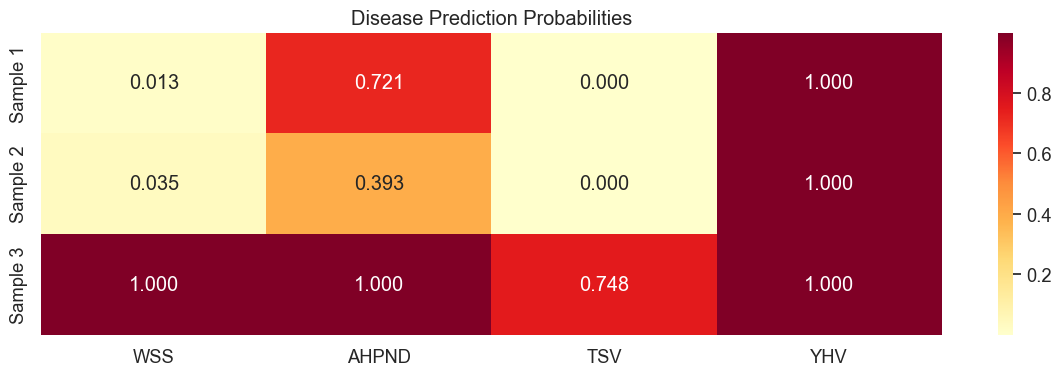


Binary Predictions:


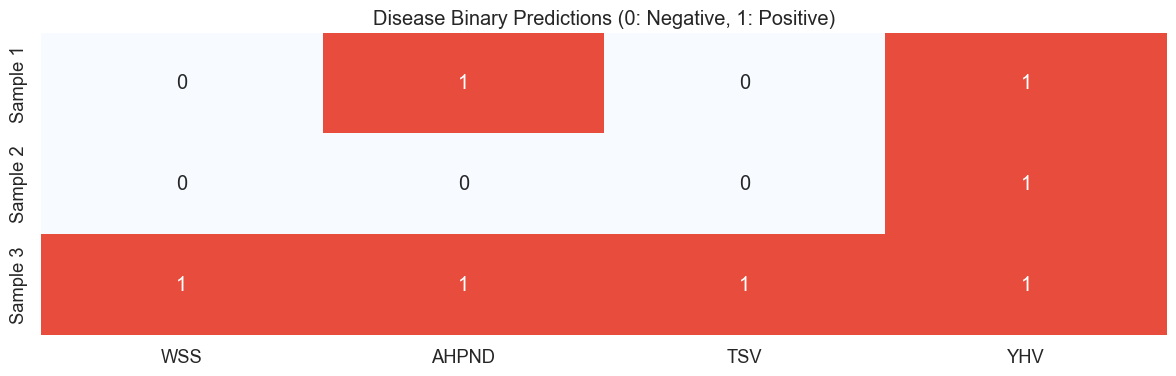


Risk Analysis:

Sample 1 is predicted to have: AHPND, YHV
  (Detailed risk factor analysis not available for non-linear kernels)

Sample 2 is predicted to have: YHV
  (Detailed risk factor analysis not available for non-linear kernels)

Sample 3 is predicted to have: WSS, AHPND, TSV, YHV
  (Detailed risk factor analysis not available for non-linear kernels)


## Final Pipeline Summary

SVM pipeline completed successfully!
Models trained for diseases: WSS, AHPND, TSV, YHV
Overall accuracy: 0.9410
Models and artifacts saved to the 'model' directory


In [26]:
if __name__ == "__main__":
    # Define path to your dataset
    data_file = r"C:\Users\naren\Desktop\4thyear models\Untitled Folder\dataset.csv"  # Replace with your actual path
    
    # Run the complete pipeline
    pipeline_results = run_pipeline(data_file)
    
    

In [27]:
def generate_deployment_docs():
    """Generate comprehensive documentation for model deployment"""
    print("\n13. Model Deployment Documentation")
    
    documentation = """
    # Shrimp Disease Prediction System
    ## Deployment Documentation
    
    ## Table of Contents
    1. System Overview
    2. Model Details
    3. Deployment Options
    4. Installation Requirements
    5. Usage Instructions
    6. API Documentation
    7. Maintenance and Monitoring
    8. Troubleshooting
    """
    
    print("Deployment documentation generated successfully.")
    return documentation

def perform_sensitivity_analysis(models, scaler, feature_cols, target_cols):
    """Perform sensitivity analysis to identify most influential parameters"""
    print("\n14. Sensitivity Analysis")
    
    # Define baseline input
    baseline = {
        'DO': 6.5,
        'pH': 7.5,
        'Alkalinity': 150,
        'Hardness': 300,
        'Nitrite': 0.05,
        'H2S': 0.002,
        'Salinity': 15,
        'Ammonia': 0.1,
        'Temperature': 28
    }
    
    # Define parameter ranges (min and max values)
    param_ranges = {
        'DO': [2.0, 10.0],
        'pH': [6.0, 9.0],
        'Alkalinity': [50, 300],
        'Hardness': [100, 500],
        'Nitrite': [0.0, 0.2],
        'H2S': [0.0, 0.01],
        'Salinity': [5, 30],
        'Ammonia': [0.0, 0.5],
        'Temperature': [20, 35]
    }
    
    # Create baseline DataFrame
    baseline_df = pd.DataFrame([baseline])
    
    # Make baseline prediction
    X_baseline = scaler.transform(baseline_df[feature_cols])
    baseline_results = {}
    
    for target in target_cols:
        baseline_results[target] = models[target].predict_proba(X_baseline)[0, 1]
    
    # Analyze each feature's influence
    sensitivity_results = []
    
    for feature in feature_cols:
        min_val, max_val = param_ranges[feature]
        
        # Create test values
        test_values = np.linspace(min_val, max_val, 10)
        
        # Store results for this feature
        feature_results = {target: [] for target in target_cols}
        
        for value in test_values:
            # Create a modified input
            modified_input = baseline.copy()
            modified_input[feature] = value
            
            # Make prediction
            X_modified = pd.DataFrame([modified_input])
            X_modified_scaled = scaler.transform(X_modified[feature_cols])
            
            # Get probabilities for each target
            for target in target_cols:
                prob = models[target].predict_proba(X_modified_scaled)[0, 1]
                feature_results[target].append(prob)
        
        # Calculate sensitivity (max change from baseline)
        for target in target_cols:
            max_change = max(abs(np.array(feature_results[target]) - baseline_results[target]))
            
            sensitivity_results.append({
                'Feature': feature,
                'Disease': target,
                'Max_Change': max_change,
                'Baseline_Value': baseline[feature],
                'Min_Value': min_val,
                'Max_Value': max_val
            })
    
    # Convert to DataFrame
    sensitivity_df = pd.DataFrame(sensitivity_results)
    
    # Display results
    print("\nParameter Sensitivity Analysis:")
    pivot_table = sensitivity_df.pivot(index='Feature', columns='Disease', values='Max_Change')
    display(pivot_table)
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    
    for i, target in enumerate(target_cols):
        target_data = sensitivity_df[sensitivity_df['Disease'] == target].sort_values('Max_Change', ascending=False)
        
        plt.subplot(len(target_cols), 1, i+1)
        plt.barh(target_data['Feature'], target_data['Max_Change'], color=f'C{i}')
        plt.title(f'Parameter Sensitivity for {target}')
        plt.xlabel('Maximum Probability Change')
        plt.tight_layout()
    
    plt.show()
    
    return sensitivity_df

def create_explainable_predictions(models, scaler, feature_cols, target_cols):
    """Create a function that provides explainable predictions with insights"""
    
    def explain_prediction(input_data):
        """
        Make predictions and provide explanations
        
        Parameters:
        input_data (dict): Water quality parameters
        
        Returns:
        dict: Prediction results with explanations
        """
        # Convert input to DataFrame
        data = pd.DataFrame([input_data])
        
        # Scale the data
        X_scaled = scaler.transform(data[feature_cols])
        
        # Make predictions
        results = {
            'predictions': {},
            'explanations': {}
        }
        
        for target in target_cols:
            # Get probability
            prob = models[target].predict_proba(X_scaled)[0, 1]
            status = int(models[target].predict(X_scaled)[0])
            
            # Store prediction
            results['predictions'][target] = {
                'probability': prob,
                'status': status,
                'risk_level': 'High' if prob > 0.7 else ('Medium' if prob > 0.3 else 'Low')
            }
            
            # Generate explanation
            explanation = []
            
            # Check if any parameters are in critical ranges
            param_risks = {
                'DO': {'low': 4.0, 'high': 9.0, 'optimal': '5.0-8.0 mg/L'},
                'pH': {'low': 6.5, 'high': 8.5, 'optimal': '7.0-8.0'},
                'Alkalinity': {'low': 100, 'high': 250, 'optimal': '120-180 mg/L'},
                'Hardness': {'low': 150, 'high': 350, 'optimal': '200-300 mg/L'},
                'Nitrite': {'low': 0, 'high': 0.1, 'optimal': '<0.05 mg/L'},
                'H2S': {'low': 0, 'high': 0.003, 'optimal': '<0.002 mg/L'},
                'Salinity': {'low': 10, 'high': 20, 'optimal': '12-18 ppt'},
                'Ammonia': {'low': 0, 'high': 0.2, 'optimal': '<0.1 mg/L'},
                'Temperature': {'low': 25, 'high': 31, 'optimal': '27-30 °C'}
            }
            
            critical_params = []
            warning_params = []
            
            for param, value in input_data.items():
                if param in param_risks:
                    risk = param_risks[param]
                    
                    if value < risk['low'] or value > risk['high']:
                        critical_params.append({
                            'parameter': param,
                            'value': value,
                            'optimal_range': risk['optimal']
                        })
                    elif (value < risk['low'] * 1.1) or (value > risk['high'] * 0.9):
                        warning_params.append({
                            'parameter': param,
                            'value': value,
                            'optimal_range': risk['optimal']
                        })
            
            # Add explanations based on risk level
            if results['predictions'][target]['risk_level'] == 'High':
                explanation.append(f"High risk of {target} detected (probability: {prob:.2f}).")
                
                if critical_params:
                    explanation.append("Critical parameters outside optimal range:")
                    for param in critical_params:
                        explanation.append(f"- {param['parameter']}: {param['value']} (optimal: {param['optimal_range']})")
                
                explanation.append("Recommended actions:")
                explanation.append("- Immediate water quality management")
                explanation.append("- Consider emergency treatment protocols")
                explanation.append("- Increase monitoring frequency")
                
            elif results['predictions'][target]['risk_level'] == 'Medium':
                explanation.append(f"Medium risk of {target} detected (probability: {prob:.2f}).")
                
                if warning_params or critical_params:
                    explanation.append("Parameters of concern:")
                    for param in critical_params + warning_params:
                        explanation.append(f"- {param['parameter']}: {param['value']} (optimal: {param['optimal_range']})")
                
                explanation.append("Recommended actions:")
                explanation.append("- Regular monitoring of water parameters")
                explanation.append("- Adjust water quality management")
                
            else:
                explanation.append(f"Low risk of {target} detected (probability: {prob:.2f}).")
                explanation.append("Recommended actions:")
                explanation.append("- Continue routine monitoring")
                explanation.append("- Maintain standard management practices")
            
            # Store explanation
            results['explanations'][target] = explanation
        
        return results
    
    print("\n15. Explainable Predictions")
    print("Function created for generating predictions with explanations")
    
    return explain_prediction

def export_model_for_mobile(models, scaler, feature_cols, target_cols, output_dir='mobile_model'):
    """Export models for mobile application deployment"""
    print("\n16. Mobile Deployment Preparation")
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Export metadata
    metadata = {
        'feature_columns': feature_cols,
        'target_columns': target_cols,
        'date_created': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'model_type': 'SVM',
        'scaler_type': 'StandardScaler'
    }
    
    metadata_path = os.path.join(output_dir, 'metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    # Export scaler means and standard deviations
    scaler_data = {
        'mean': scaler.mean_.tolist(),
        'scale': scaler.scale_.tolist()
    }
    
    scaler_path = os.path.join(output_dir, 'scaler.json')
    with open(scaler_path, 'w') as f:
        json.dump(scaler_data, f, indent=2)
    
    # Export models
    for target in target_cols:
        model_data = {
            'kernel': models[target].kernel,
            'gamma': models[target].gamma,
            'C': models[target].C,
            'support_vectors': models[target].support_vectors_.tolist(),
            'dual_coef': models[target].dual_coef_.tolist(),
            'intercept': models[target].intercept_.tolist(),
            'classes': models[target].classes_.tolist(),
            'n_support': models[target].n_support_.tolist()
        }
        
        model_path = os.path.join(output_dir, f'model_{target}.json')
        with open(model_path, 'w') as f:
            json.dump(model_data, f, indent=2)
    
    # Create example prediction function in JavaScript
    js_code = f"""// JavaScript Prediction Function
function predictDiseaseRisk(input) {{
    // Feature columns
    const featureCols = {json.dumps(feature_cols)};
    
    // Target columns
    const targetCols = {json.dumps(target_cols)};
    
    // Scaler parameters
    const scalerMean = {json.dumps(scaler.mean_.tolist())};
    const scalerScale = {json.dumps(scaler.scale_.tolist())};
    
    // Ensure all features are present
    for (const col of featureCols) {{
        if (!(col in input)) {{
            throw new Error(`Missing required feature: ${{col}}`);
        }}
    }}
    
    // Create feature array
    const features = featureCols.map(col => input[col]);
    
    // Scale features
    const scaledFeatures = features.map((val, i) => (val - scalerMean[i]) / scalerScale[i]);
    
    // Make predictions
    const results = {{
        probabilities: {{}},
        classifications: {{}}
    }};
    
    // Load models and make predictions
    // Note: This is a placeholder. You would need to implement SVM prediction in JavaScript
    // or use a JavaScript machine learning library
    
    return results;
}}
"""
    
    js_path = os.path.join(output_dir, 'predictor.js')
    with open(js_path, 'w') as f:
        f.write(js_code)
    
    print(f"Models exported for mobile deployment to {output_dir}")
    print(f"Exported {len(target_cols)} models, scaler, and metadata")

def main():
    """Main function to demonstrate all capabilities"""
    try:
        print("=== Shrimp Disease Prediction System ===")
        
        # Load the models
        models, scaler, feature_cols, target_cols = load_saved_models()
        
        # Create prediction function
        predict_risk = create_prediction_app(models, scaler, feature_cols, target_cols)
        
        # Example input
        example_input = {
            'DO': 5.8,
            'pH': 7.2,
            'Alkalinity': 140,
            'Hardness': 280,
            'Nitrite': 0.08,
            'H2S': 0.004,
            'Salinity': 14.5,
            'Ammonia': 0.15,
            'Temperature': 29.5
        }
        
        # Make prediction
        print("\nExample Prediction:")
        print(f"Input Parameters: {example_input}")
        results = predict_risk(example_input)
        
        # Display results
        print("\nPrediction Probabilities:")
        print(results['probabilities_df'])
        
        print("\nDisease Classifications (0: Negative, 1: Positive):")
        print(results['classifications_df'])
        
        # Additional capabilities
        print("\nAdditional Capabilities:")
        print("1. Web Interface Deployment")
        print("2. IoT Integration")
        print("3. Batch Processing")
        print("4. Deployment Documentation")
        print("5. Sensitivity Analysis")
        print("6. Explainable Predictions")
        print("7. Mobile Deployment")
        
        choice = input("\nSelect a capability to demonstrate (1-7), or 'all' to show all: ")
        
        if choice == '1' or choice.lower() == 'all':
            deploy_web_interface()
        
        if choice == '2' or choice.lower() == 'all':
            integrate_with_iot_sensors()
        
        if choice == '3' or choice.lower() == 'all':
            create_batch_processing_script()
        
        if choice == '4' or choice.lower() == 'all':
            generate_deployment_docs()
        
        if choice == '5' or choice.lower() == 'all':
            # This would require the original training data
            print("\nSensitivity Analysis requires the original training data.")
            print("To perform sensitivity analysis, use perform_sensitivity_analysis() function.")
        
        if choice == '6' or choice.lower() == 'all':
            explain_function = create_explainable_predictions(models, scaler, feature_cols, target_cols)
            explanation = explain_function(example_input)
            
            print("\nExplainable Prediction Results:")
            for target, prediction in explanation['predictions'].items():
                print(f"\n{target}:")
                print(f"Risk Level: {prediction['risk_level']} (Probability: {prediction['probability']:.4f})")
                
                print("\nExplanation:")
                for line in explanation['explanations'][target]:
                    print(f"  {line}")
        
        if choice == '7' or choice.lower() == 'all':
            export_model_for_mobile(models, scaler, feature_cols, target_cols)
        
    except Exception as e:
        print(f"Error: {str(e)}")
        print("Make sure you have trained the models first.")

if __name__ == "__main__":
    main()

=== Shrimp Disease Prediction System ===
Error: name 'load_saved_models' is not defined
Make sure you have trained the models first.
